In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from copy import deepcopy

In [59]:
from plaid.datasets import CATHShardedDataModule
dm = CATHShardedDataModule(
    shard_dir ="/shared/amyxlu/data/cath/shards",
    header_to_sequence_file="/shared/amyxlu/data/cath/sequences.pkl",
    seq_len=64,
    dtype="fp32",
)
dm.setup()
loader = dm.val_dataloader()
batch = next(iter(loader))

See `09_examine_latent_dim.ipynb` -- these channels were selected for having absolute values greater than 20.

In [51]:
seq_to_header = {v: k for k, v in dm.train_dataset.header_to_seq.items()}
headers = [seq_to_header[seq] for seq in batch[-1]]
cath_ids = [s.split("|")[-1].split("/")[0] for s in headers]
cath_ids[:3]

['1dpsA00', '1jwqA00', '4an6B00']

In [52]:
original_cath_structures = []
for cath_id in cath_ids:
    with open(f"/shared/amyxlu/data/cath/full/dompdb/{cath_id}") as f:
        original_cath_structures.append(f.read())

In [4]:
OUTLIER_CHANNELS = [274, 641, 37]
device = torch.device("cuda:0")

In [5]:
from plaid.esmfold import esmfold_v1
esmfold = esmfold_v1()
esmfold = esmfold.to(device)
esmfold = esmfold.eval().requires_grad_(False)

In [6]:
x, mask, seq = batch

x_zeros = deepcopy(x)
x_zeros[:, :, OUTLIER_CHANNELS] = 0
x, _, x_zeros = x.to(device), mask.to(device), x_zeros.to(device)

In [7]:
from plaid.esmfold import batch_encode_sequences

seq = [s[:64] for s in seq]
aatype, mask, residx, linker_mask, chain_index_list = batch_encode_sequences(seq)

aatype = aatype.to(device)
residx = residx.to(device)
mask = mask.to(device)

In [14]:
output = esmfold.infer(seq)
output.keys()

dict_keys(['frames', 'sidechain_frames', 'unnormalized_angles', 'angles', 'positions', 'states', 'single', 'sm_s', 'sm_z', 's_s', 's_z', 'distogram_logits', 'lm_logits', 'aatype', 'atom14_atom_exists', 'residx_atom14_to_atom37', 'residx_atom37_to_atom14', 'atom37_atom_exists', 'residue_index', 'lddt_head', 'plddt', 'ptm_logits', 'ptm', 'aligned_confidence_probs', 'predicted_aligned_error', 'max_predicted_aligned_error', 'mean_plddt', 'chain_index'])

In [42]:
from plaid.esmfold import output_to_pdb
esmfold_gt = output_to_pdb(output)

# Comparing structure from sequence vs. from latent

In [20]:
from plaid.esmfold import make_s_z_0
z = make_s_z_0(x)

In [28]:
structure_from_latent = esmfold.folding_trunk(x, z, aatype, residx, mask, num_recycles=4)

In [31]:
structure_from_latent_pdb = output_to_pdb(structure_from_latent)

In [34]:
from plaid.utils import run_tmalign
tmscores = [run_tmalign(from_seq, from_latent) for (from_seq, from_latent) in zip(esmfold_gt, structure_from_latent_pdb)]

saved query to /home/amyxlu/.tmp/query.pdb
saved reference to /home/amyxlu/.tmp/reference.pdb
saved query to /home/amyxlu/.tmp/query.pdb
saved reference to /home/amyxlu/.tmp/reference.pdb
saved query to /home/amyxlu/.tmp/query.pdb
saved reference to /home/amyxlu/.tmp/reference.pdb
saved query to /home/amyxlu/.tmp/query.pdb
saved reference to /home/amyxlu/.tmp/reference.pdb
saved query to /home/amyxlu/.tmp/query.pdb
saved reference to /home/amyxlu/.tmp/reference.pdb
saved query to /home/amyxlu/.tmp/query.pdb
saved reference to /home/amyxlu/.tmp/reference.pdb
saved query to /home/amyxlu/.tmp/query.pdb
saved reference to /home/amyxlu/.tmp/reference.pdb
saved query to /home/amyxlu/.tmp/query.pdb
saved reference to /home/amyxlu/.tmp/reference.pdb
saved query to /home/amyxlu/.tmp/query.pdb
saved reference to /home/amyxlu/.tmp/reference.pdb
saved query to /home/amyxlu/.tmp/query.pdb
saved reference to /home/amyxlu/.tmp/reference.pdb
saved query to /home/amyxlu/.tmp/query.pdb
saved reference t

(array([1., 0., 3., 3., 3., 6., 7., 2., 2., 0., 1., 0., 1., 1., 1., 0., 0.,
        0., 0., 1.]),
 array([0.13455  , 0.1581795, 0.181809 , 0.2054385, 0.229068 , 0.2526975,
        0.276327 , 0.2999565, 0.323586 , 0.3472155, 0.370845 , 0.3944745,
        0.418104 , 0.4417335, 0.465363 , 0.4889925, 0.512622 , 0.5362515,
        0.559881 , 0.5835105, 0.60714  ]),
 <BarContainer object of 20 artists>)

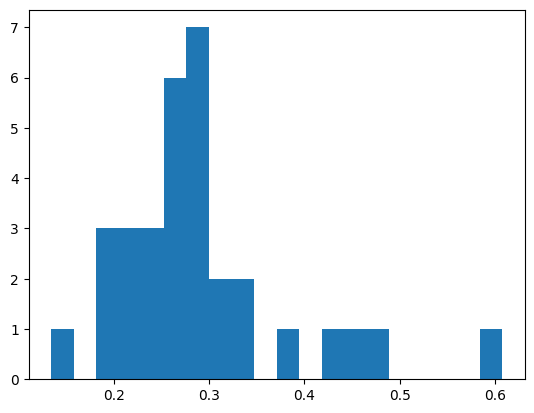

In [35]:
plt.hist(tmscores, bins=20)

In [55]:
import py3Dmol

for i in range(10):
    view = py3Dmol.view(width=400, height=300)
    view.addModelsAsFrames(esmfold_gt[i])
    view.addModelsAsFrames(structure_from_latent_pdb[i])
    view.addModelsAsFrames(original_cath_structures[i])
    view.setStyle({"model": 0}, {"cartoon": {"color": "red", "transparency": 0.5}})
    view.setStyle({"model": 1}, {"cartoon": {"color": "green", "transparency": 0.5}})
    view.setStyle({"model": 2}, {"cartoon": {"color": "gray", "transparency": 0.5}})
    view.zoomTo()
    view.show()


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# Examining `sm_s` and `sm_z`

tensor(40671.1992, device='cuda:0')
tensor(-4262.0137, device='cuda:0')


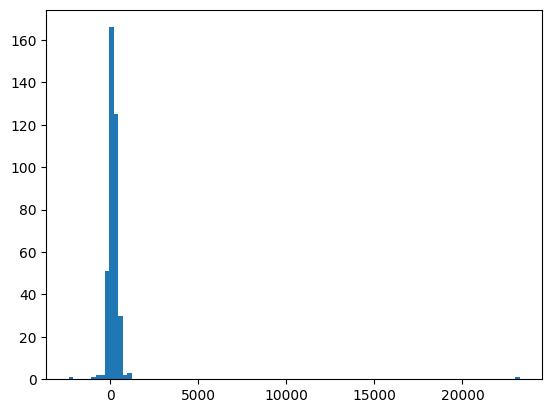

In [9]:
print(output['sm_s'].max())
print(output['sm_s'].min())
_ = plt.hist(output['sm_s'].mean(dim=(0,1)).cpu().numpy(), bins=100)

tensor(862.1744, device='cuda:0')
tensor(-591.7253, device='cuda:0')


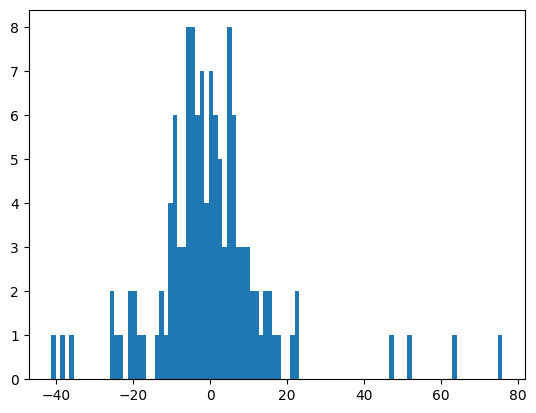

In [10]:
print(output['sm_z'].max())
print(output['sm_z'].min())
_ = plt.hist(output['sm_z'].mean(dim=(0,1,2)).cpu().numpy(), bins=100)